In [4]:
print("Renseigner dans fileData le nom et le chemin de votre fichier skymap")

Renseigner dans fileData le nom et le chemin de votre fichier skymap


In [5]:
fileData = '/home/lavergne/these/enseignement/astrogammaTP/RECH601/astrogamma/tp/skymap.fits'
print(fileData)

/home/lavergne/these/enseignement/astrogammaTP/RECH601/astrogamma/tp/skymap.fits


Cen A: RA = 201.36370326497382 deg, Dec = -43.02543482604194 deg
Cen A: Position uncertainty = 0.021697620860821595 deg


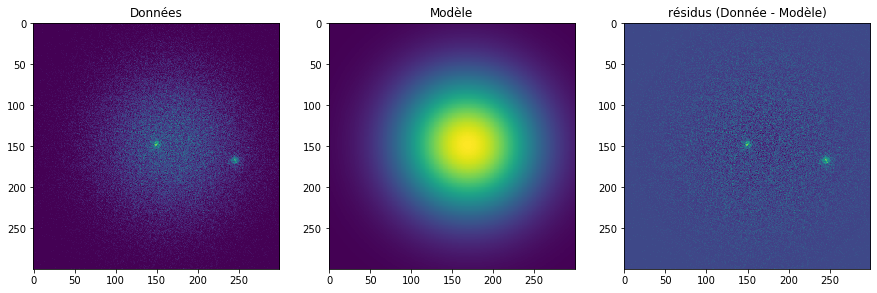

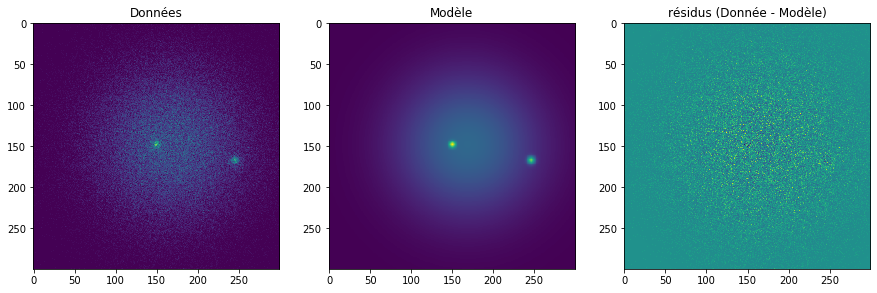

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from astropy.io import fits
from astropy.wcs import WCS

controlPlot = True


########################################### Read data and find position of sources bu modelling the spatial emision ################################################
file = fits.open(fileData)
image= file[0].data
cdelt = np.abs(file[0].header['CDELT1'])

x,y=np.mgrid[:image.shape[0],:image.shape[1]]
fit_p = fitting.LevMarLSQFitter()

modelBackground =  models.Gaussian2D(amplitude=15.2,x_mean=image.shape[0]/2,y_mean=image.shape[1]/2)

#Fit background
modelBackground = fit_p(modelBackground, x, y, image)
# Contol plot
if controlPlot:
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1, title='Données')
    plt.imshow(image)
    plt.subplot(1,3,2, title='Modèle')
    plt.imshow(modelBackground(x, y))
    plt.subplot(1,3,3, title='résidus (Donnée - Modèle)')
    plt.imshow(image-modelBackground(x, y))

modelSourceCenA = models.Gaussian2D(amplitude=15.2,x_mean=image.shape[0]/2,y_mean=image.shape[1]/2)
modelSource2 = models.Gaussian2D(amplitude=15.2,x_mean=0.56*image.shape[0],y_mean=0.81*image.shape[1])
imageModel = modelBackground+modelSourceCenA+modelSource2
#Make a symmetric gaussian
imageModel.y_stddev_1.tied = lambda model : model.x_stddev_1
imageModel.y_stddev_2.tied = lambda model : model.x_stddev_2
imageModel.theta_1.fixed = True
imageModel.theta_2.fixed = True

#Fit model with source       
imageModel = fit_p(imageModel, x, y, image, maxiter=500)
# Contol plot
if controlPlot:
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1, title='Données')
    plt.imshow(image)
    plt.subplot(1,3,2, title='Modèle')
    plt.imshow(imageModel(x, y))
    plt.subplot(1,3,3, title='résidus (Donnée - Modèle)')
    plt.imshow((image-imageModel(x, y)))

covMatrix = fit_p.fit_info['param_cov']
errVector = np.sqrt(covMatrix.diagonal())
    
coodSystem = WCS(fileData)


#Determine position of Cen A
positionCenA = coodSystem.pixel_to_world(imageModel.y_mean_1.value, imageModel.x_mean_1.value)
errPositionCenA = np.mean([errVector[7],errVector[8]])*cdelt

print("Cen A: RA = "+str(positionCenA.ra.deg)+ " deg, Dec = " + str(positionCenA.dec.deg) + " deg")
print("Cen A: Position uncertainty = "+str(errPositionCenA)+ " deg")


In [7]:
#determine position of source 2
positionSrc2 = coodSystem.pixel_to_world(imageModel.y_mean_2.value, imageModel.x_mean_2.value)
errPositionSrc2 = np.mean([errVector[11],errVector[12]])*cdelt

print("Source 2: RA = "+str(positionSrc2.ra.deg)+ " deg, Dec = " + str(positionSrc2.dec.deg) + " deg")
print("Source 2: Position uncertainty = "+str(errPositionSrc2)+ " deg")

Source 2: RA = 198.75975794409223 deg, Dec = -42.61529873517269 deg
Source 2: Position uncertainty = 0.02302773358353497 deg
